In [17]:
import pandas as pd
import requests
from io import StringIO
import json

# --- Core Helper Function ---

def fetch_nyfed_data(endpoint: str, data_format: str = 'json'):
    """
    A helper function to fetch data from the NY Fed API.

    Args:
        endpoint (str): The specific API endpoint to query after '/api/'.
        data_format (str): The desired format ('json', 'xml', 'csv').
                           Defaults to 'json'.

    Returns:
        pandas.DataFrame: A DataFrame containing the requested data,
                          or None if the request fails.
    """
    BASE_URL = "https://markets.newyorkfed.org/api"
    # The API uses .csv for some endpoints in the path itself
    if data_format == 'csv':
        url = f"{BASE_URL}/{endpoint}"
    else:
        url = f"{BASE_URL}/{endpoint}.{data_format}"

    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()  # Raises an HTTPError for bad responses (4XX or 5XX)

        if data_format == 'json':
            # The actual data is often nested under one or more keys
            data = response.json()
            # Common root keys observed in the API
            root_keys = ['soma', 'repo', 'ambs', 'markets', 'rates', 'securitiesLending', 'centralBankLiquiditySwaps']
            data_key = next((key for key in root_keys if key in data), None)

            if data_key and isinstance(data[data_key], dict):
                # Find the list within the dictionary
                list_key = next((key for key in data[data_key] if isinstance(data[data_key][key], list)), None)
                if list_key:
                    return pd.DataFrame(data[data_key][list_key])

            # Fallback for simpler JSON structures
            if data_key and isinstance(data[data_key], list):
                 return pd.DataFrame(data[data_key])

            print(f"Warning: Could not automatically find data list in JSON response for endpoint: {endpoint}")
            return None

        elif data_format == 'csv':
            return pd.read_csv(StringIO(response.text))

        else:
            print(f"Unsupported format: {data_format}")
            return None

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from {url}: {e}")
        return None
    except json.JSONDecodeError:
        print(f"Error decoding JSON from {url}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred for endpoint {endpoint}: {e}")
        return None


# --- SOMA Holdings Functions ---

def get_soma_holdings_summary():
    """Gets the total SOMA holdings by security type."""
    return fetch_nyfed_data("soma/summary")

def get_soma_treasury_holdings(date: str = 'latest'):
    """Gets SOMA Treasury holdings for a specific date (YYYY-MM-DD) or 'latest'."""
    return fetch_nyfed_data(f"soma/tsy/get/asof/{date}")

def get_soma_agency_mbs_holdings(date: str = 'latest'):
    """Gets SOMA Agency MBS holdings for a specific date (YYYY-MM-DD) or 'latest'."""
    return fetch_nyfed_data(f"soma/agency/get/asof/{date}")


# --- Repo and Reverse Repo Functions ---

def search_repo_operations(op_type: str = 'repo', start_date: str = '', end_date: str = ''):
    """
    Searches for repo or reverse repo operations within a date range.
    Args:
        op_type (str): 'repo' or 'reverserepo'.
        start_date (str): Start date in YYYY-MM-DD format.
        end_date (str): End date in YYYY-MM-DD format.
    """
    endpoint = f"rp/results/search?opType={op_type}&startDate={start_date}&endDate={end_date}"
    return fetch_nyfed_data(endpoint)


# --- Reference Rate Functions ---

def search_reference_rates(rate_type: str, last_n: int = 90):
    """
    Gets the last 'n' observations for a given secured or unsecured reference rate.
    Args:
        rate_type (str): e.g., 'SOFR', 'BGCR', 'TGCR', 'OBFR', 'EFFR'.
        last_n (int): The number of recent observations to retrieve.
    """
    rate_type_map = {
        # Secured
        'SOFR': 'secured/SOFR', 'BGCR': 'secured/BGCR', 'TGCR': 'secured/TGCR',
        # Unsecured
        'OBFR': 'unsecured/OBFR', 'EFFR': 'unsecured/EFFR'
    }
    if rate_type.upper() not in rate_type_map:
        raise ValueError(f"Invalid rate_type. Use one of {list(rate_type_map.keys())}")

    endpoint = f"rates/{rate_type_map[rate_type.upper()]}/last/{last_n}"
    return fetch_nyfed_data(endpoint)


# --- Primary Dealer Statistics Function ---

def get_all_primary_dealer_surveys():
    """
    Retrieves the entire time series of Primary Dealer surveys.
    Note: This is a large dataset.
    """
    return fetch_nyfed_data("pd/get/all/timeseries", data_format='csv')

In [18]:
# --- Example 1: Get the latest SOMA Treasury holdings ---
soma_treasuries_latest = get_soma_treasury_holdings()
print("Latest SOMA Treasury Holdings:")
if soma_treasuries_latest is not None:
    print(soma_treasuries_latest.head())

# --- Example 2: Search Reverse Repo operations for the last month ---
from datetime import datetime, timedelta
today = datetime.now()
one_month_ago = today - timedelta(days=30)
start_date_str = one_month_ago.strftime('%Y-%m-%d')
end_date_str = today.strftime('%Y-%m-%d')

reverse_repo_data = search_repo_operations(
    op_type='reverserepo',
    start_date=start_date_str,
    end_date=end_date_str
)
print(f"\nReverse Repo Operations from {start_date_str} to {end_date_str}:")
if reverse_repo_data is not None:
    print(reverse_repo_data.head())


# --- Example 3: Get the last 90 days of SOFR data ---
sofr_90d = search_reference_rates(rate_type='SOFR', last_n=90)
print("\nLast 90 Days of SOFR Data:")
if sofr_90d is not None:
    # Set date as index for potential plotting
    sofr_90d['rateDate'] = pd.to_datetime(sofr_90d['rateDate'])
    sofr_90d.set_index('rateDate', inplace=True)
    print(sofr_90d.head())

Error fetching data from https://markets.newyorkfed.org/api/soma/tsy/get/asof/latest.json: 400 Client Error: Bad Request for url: https://markets.newyorkfed.org/api/soma/tsy/get/asof/latest.json
Latest SOMA Treasury Holdings:
Error fetching data from https://markets.newyorkfed.org/api/rp/results/search?opType=reverserepo&startDate=2025-07-01&endDate=2025-07-31.json: 400 Client Error: Bad Request for url: https://markets.newyorkfed.org/api/rp/results/search?opType=reverserepo&startDate=2025-07-01&endDate=2025-07-31.json

Reverse Repo Operations from 2025-07-01 to 2025-07-31:

Last 90 Days of SOFR Data:


In [19]:
# Get the summary of SOMA holdings
soma_summary = get_soma_holdings_summary()
if soma_summary is not None:
    display(soma_summary)

# Get SOFR data for the last 30 days
sofr_data_30d = search_reference_rates(rate_type='SOFR', last_n=30)
if sofr_data_30d is not None:
    display(sofr_data_30d)

,asOfDate,mbs,cmbs,tips,frn,tipsInflationCompensation,notesbonds,bills,agencies,total
0,2003-07-09,0.00,0.00,12814483000,,928695000,398852847000,239304992000,10000000,650982322000.00
1,2003-07-16,0.00,0.00,12814483000,,928695000,398852847000,239549686000,10000000,651227016000.00
2,2003-07-23,0.00,0.00,12814483000,,1468195000,398852847000,239691886000,10000000,651369216000.00
3,2003-07-30,0.00,0.00,12814483000,,928695000,398852847000,239725686000,10000000,651403016000.00
4,2003-08-06,0.00,0.00,12814483000,,1465167000,398852847000,239891686000,10000000,651569016000.00
...,...,...,...,...,...,...,...,...,...,...
1147,2025-07-02,2130562970558.50,7932545620.20,316031178200,10532824100,111624468637.77,3574718389600,195417926700,2347000000,6237542834778.70
1148,2025-07-09,2130562970558.50,7932545620.20,316031178200,10532824100,111826106189.86,3574718389600,195417926700,2347000000,6237542834778.70
1149,2025-07-16,2130498581290.20,7927794429.50,307997178200,10532824100,109181976458.78,3583318204600,195492926700,2347000000,6238114509319.70
1150,2025-07-23,2126855880617.80,7927794429.50,307997178200,10532824100,109378701926.85,3583318204600,195492926700,2347000000,6234471808647.30


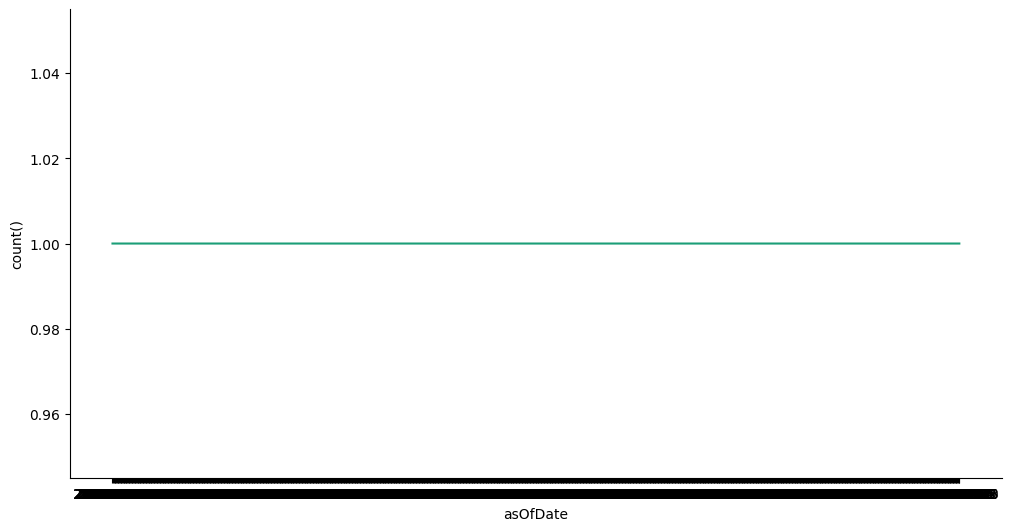

In [20]:
# @title asOfDate vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['asOfDate']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'asOfDate'}, axis=1)
              .sort_values('asOfDate', ascending=True))
  xs = counted['asOfDate']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = soma_summary.sort_values('asOfDate', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('asOfDate')
_ = plt.ylabel('count()')

In [21]:
# Assume the functions from the previous cell have been run

# --- Example 1: Get latest SOMA Agency MBS holdings ---
soma_agency_mbs = get_soma_agency_mbs_holdings(date='latest')
print("--- Latest SOMA Agency MBS Holdings ---")
if soma_agency_mbs is not None:
    print(soma_agency_mbs.head())


# Next steps:
# Colab paid products - Cancel contracts here

Error fetching data from https://markets.newyorkfed.org/api/soma/agency/get/asof/latest.json: 400 Client Error: Bad Request for url: https://markets.newyorkfed.org/api/soma/agency/get/asof/latest.json
--- Latest SOMA Agency MBS Holdings ---


In [22]:
# Display the data types of each column in soma_summary
print("Data types of soma_summary DataFrame:")
print(soma_summary.dtypes)

# Display basic descriptive statistics for numerical columns
print("\nBasic descriptive statistics for soma_summary DataFrame:")
display(soma_summary.describe())

Data types of soma_summary DataFrame:
asOfDate                     object
mbs                          object
cmbs                         object
tips                         object
frn                          object
tipsInflationCompensation    object
notesbonds                   object
bills                        object
agencies                     object
total                        object
dtype: object

Basic descriptive statistics for soma_summary DataFrame:


,asOfDate,mbs,cmbs,tips,frn,tipsInflationCompensation,notesbonds,bills,agencies,total
count,1152,1152,1152,1152,1152,1152,1152,1152,1152,1152
unique,1152,778,154,306,63,1149,672,215,198,1024
top,2025-04-09,0.00,0.00,98534104200,,928695000,470984109000,0,2347000000,473302960000.00
freq,1,288,873,43,567,4,14,342,332,14


In [23]:
import pandas as pd
import requests
from io import StringIO

url = "https://markets.newyorkfed.org/api/pd/get/all/timeseries.csv"

try:
    response = requests.get(url)
    response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)

    # Read the CSV data into a pandas DataFrame
    primary_dealer_df = pd.read_csv(StringIO(response.text))

    print("Primary Dealer Surveys Data:")
    display(primary_dealer_df.head())
    print("\nData types:")
    print(primary_dealer_df.dtypes)

except requests.exceptions.RequestException as e:
    print(f"Error fetching data from {url}: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Primary Dealer Surveys Data:


,As Of Date,Time Series,Value (millions)
0,2025-07-23,PDPOSCSBND-BELG10,771
1,2025-07-23,PDPOSCSBND-G13C,1460
2,2025-07-23,PDPOSCSBND-G10C,-740
3,2025-07-23,PDPOSCSBND-BELG13C,-209
4,2025-07-23,PDPOSABS-CCB,319



Data types:
As Of Date          object
Time Series         object
Value (millions)    object
dtype: object


# Task
Analyze and visualize trends and correlations in the provided SOMA holdings data from "https://markets.newyorkfed.org/api/pd/get/all/timeseries.csv".

## Prepare `soma summary` data

### Subtask:
Convert the 'asOfDate' column to datetime objects and the value columns to numeric types in the `soma_summary` DataFrame for time series analysis and visualization.


**Reasoning**:
Convert the 'asOfDate' column to datetime and the value columns to numeric in the `soma_summary` DataFrame to prepare for analysis and visualization.



In [24]:
soma_summary['asOfDate'] = pd.to_datetime(soma_summary['asOfDate'])

value_columns = soma_summary.columns.drop('asOfDate')

for col in value_columns:
    soma_summary[col] = pd.to_numeric(soma_summary[col], errors='coerce')

print("Data types after conversion:")
print(soma_summary.dtypes)
print("\nFirst few rows after conversion:")
display(soma_summary.head())

Data types after conversion:
asOfDate                     datetime64[ns]
mbs                                 float64
cmbs                                float64
tips                                  int64
frn                                 float64
tipsInflationCompensation           float64
notesbonds                            int64
bills                                 int64
agencies                            float64
total                               float64
dtype: object

First few rows after conversion:


,asOfDate,mbs,cmbs,tips,frn,tipsInflationCompensation,notesbonds,bills,agencies,total
0,2003-07-09,0.0,0.0,12814483000,NaN,9.286950e+08,398852847000,239304992000,10000000.0,6.509823e+11
1,2003-07-16,0.0,0.0,12814483000,NaN,9.286950e+08,398852847000,239549686000,10000000.0,6.512270e+11
2,2003-07-23,0.0,0.0,12814483000,NaN,1.468195e+09,398852847000,239691886000,10000000.0,6.513692e+11
3,2003-07-30,0.0,0.0,12814483000,NaN,9.286950e+08,398852847000,239725686000,10000000.0,6.514030e+11
4,2003-08-06,0.0,0.0,12814483000,NaN,1.465167e+09,398852847000,239891686000,10000000.0,6.515690e+11


## Visualize `soma summary` trends

### Subtask:
Plot the total SOMA holdings over time, and potentially individual security types as requested.


**Reasoning**:
Create line plots for total SOMA holdings and selected individual security types over time using the cleaned `soma_summary` DataFrame.



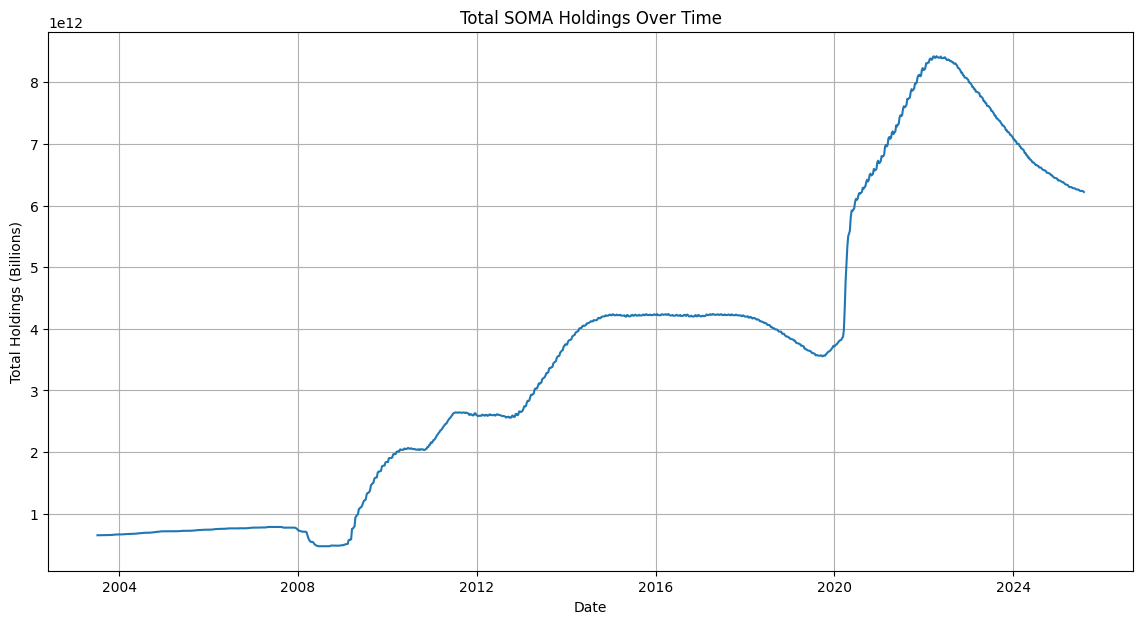

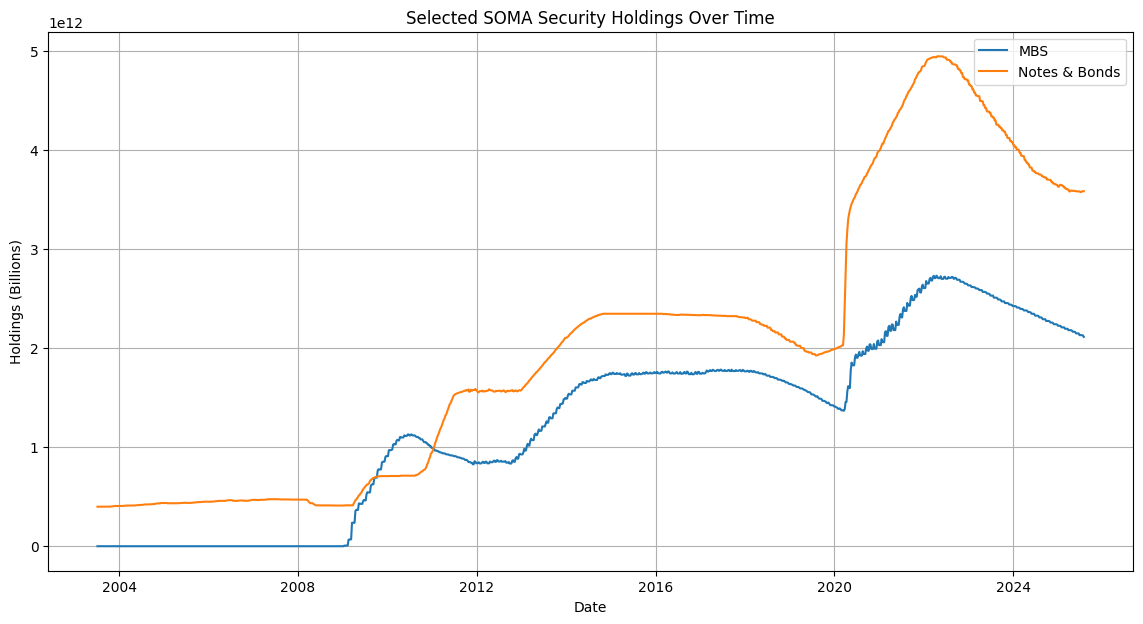

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set 'asOfDate' as the index
soma_summary_indexed = soma_summary.set_index('asOfDate')

# Plot Total SOMA Holdings Over Time
plt.figure(figsize=(14, 7))
sns.lineplot(data=soma_summary_indexed, x=soma_summary_indexed.index, y='total')
plt.title('Total SOMA Holdings Over Time')
plt.xlabel('Date')
plt.ylabel('Total Holdings (Billions)') # Assuming values are large, adjust label
plt.grid(True)
plt.show()

# Plot selected individual security types over time (Optional)
plt.figure(figsize=(14, 7))
sns.lineplot(data=soma_summary_indexed, x=soma_summary_indexed.index, y='mbs', label='MBS')
sns.lineplot(data=soma_summary_indexed, x=soma_summary_indexed.index, y='notesbonds', label='Notes & Bonds')
plt.title('Selected SOMA Security Holdings Over Time')
plt.xlabel('Date')
plt.ylabel('Holdings (Billions)') # Assuming values are large, adjust label
plt.legend()
plt.grid(True)
plt.show()

## Analyze `soma summary` correlations

### Subtask:
Calculate and visualize the correlations between different types of SOMA holdings.


**Reasoning**:
Calculate the correlation matrix for the numerical columns in the `soma_summary` DataFrame and visualize it using a heatmap.



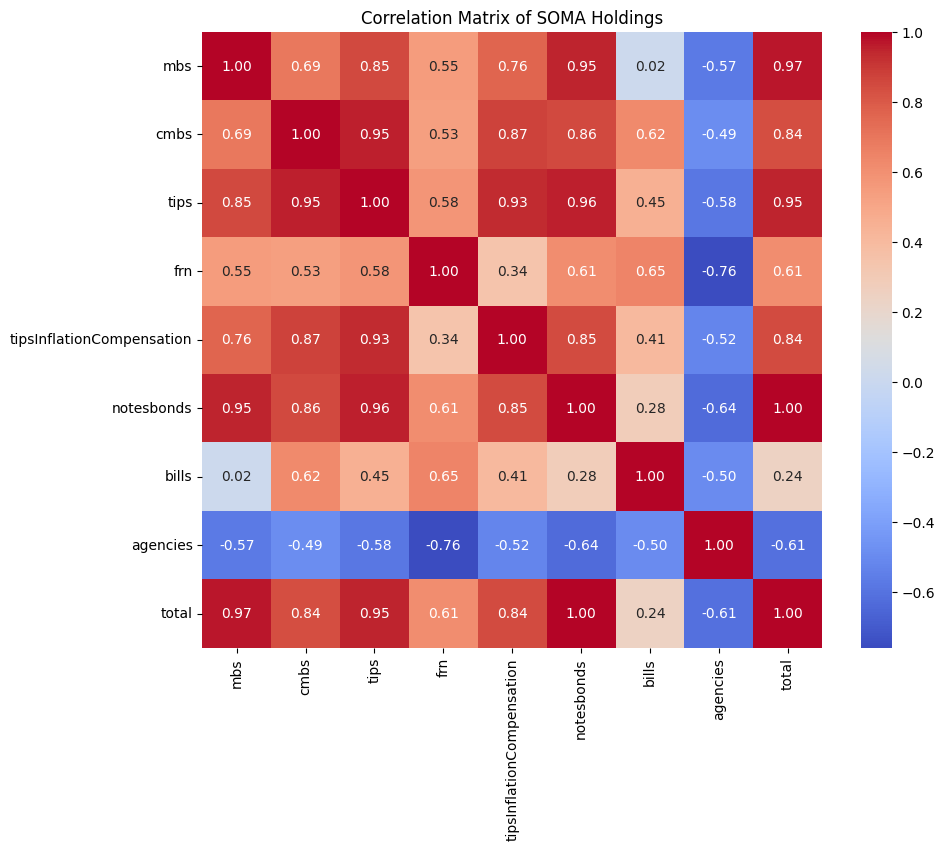

In [26]:
# Calculate the correlation matrix
correlation_matrix = soma_summary.corr(numeric_only=True)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of SOMA Holdings')
plt.show()

## Prepare `primary dealer df` data

### Subtask:
Convert the 'As Of Date' column to datetime objects and the 'Value (millions)' column to numeric type in the `primary_dealer_df` DataFrame.


**Reasoning**:
Convert the 'As Of Date' column to datetime and 'Value (millions)' to numeric to enable time series analysis and numerical operations. Then, print dtypes and head to verify.



In [27]:
primary_dealer_df['As Of Date'] = pd.to_datetime(primary_dealer_df['As Of Date'])
primary_dealer_df['Value (millions)'] = pd.to_numeric(primary_dealer_df['Value (millions)'], errors='coerce')

print("Data types after conversion:")
print(primary_dealer_df.dtypes)

print("\nFirst few rows after conversion:")
display(primary_dealer_df.head())

Data types after conversion:
As Of Date          datetime64[ns]
Time Series                 object
Value (millions)           float64
dtype: object

First few rows after conversion:


,As Of Date,Time Series,Value (millions)
0,2025-07-23,PDPOSCSBND-BELG10,771.0
1,2025-07-23,PDPOSCSBND-G13C,1460.0
2,2025-07-23,PDPOSCSBND-G10C,-740.0
3,2025-07-23,PDPOSCSBND-BELG13C,-209.0
4,2025-07-23,PDPOSABS-CCB,319.0


## Explore `primary dealer df` time series

### Subtask:
Identify and display the unique values in the 'Time Series' column to understand the different types of surveys available.


**Reasoning**:
Access the 'Time Series' column, get the unique values, and display them.



In [28]:
unique_time_series = primary_dealer_df['Time Series'].unique()
print("Unique values in 'Time Series' column:")
print(unique_time_series)

Unique values in 'Time Series' column:
['PDPOSCSBND-BELG10' 'PDPOSCSBND-G13C' 'PDPOSCSBND-G10C' ... 'PDSUSGTBPT'
 'PDSUSGTIISFT' 'PDSUSGTIISPT']


## Visualize `primary dealer df` trends

### Subtask:
Filter the `primary_dealer_df` data for a specific time series and visualize its trend over time.


**Reasoning**:
Filter the dataframe for a chosen time series, set the date as index, and plot the 'Value (millions)' column to visualize the trend.



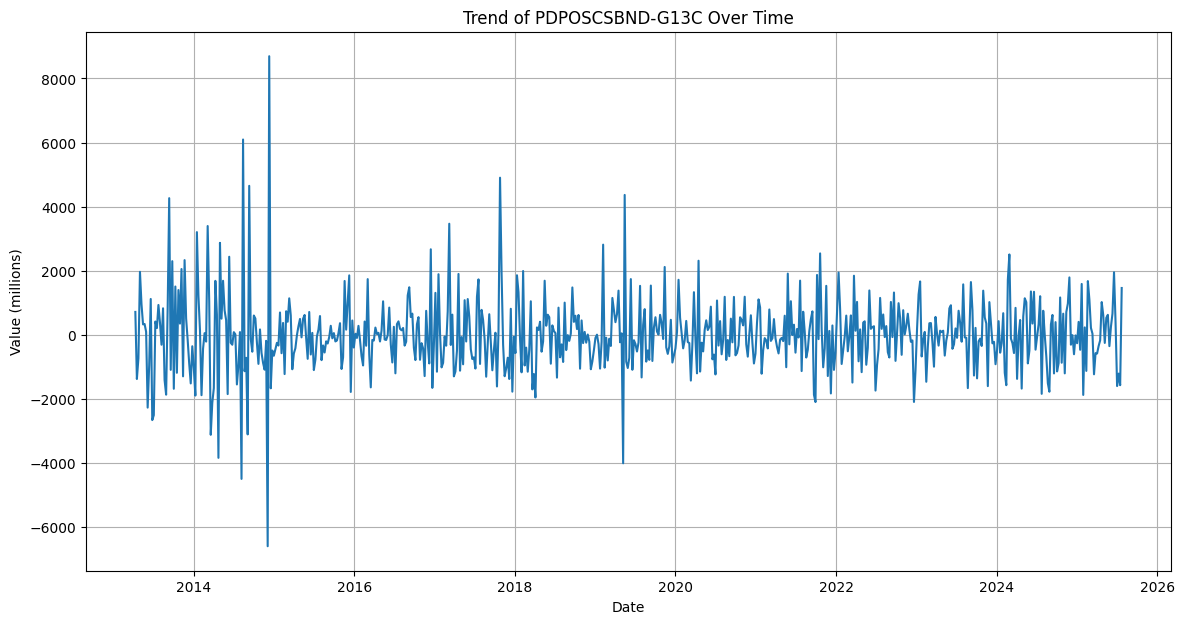

In [29]:
# Choose a specific 'Time Series' value
chosen_time_series = 'PDPOSCSBND-G13C' # Example value from the unique list

# Filter the DataFrame for the chosen time series
filtered_df = primary_dealer_df[primary_dealer_df['Time Series'] == chosen_time_series].copy()

# Set the 'As Of Date' column as the index
filtered_df.set_index('As Of Date', inplace=True)

# Create a line plot of the 'Value (millions)' column
plt.figure(figsize=(14, 7))
sns.lineplot(data=filtered_df, x=filtered_df.index, y='Value (millions)')

# Add title and labels
plt.title(f"Trend of {chosen_time_series} Over Time")
plt.xlabel('Date')
plt.ylabel('Value (millions)')

# Display the plot
plt.grid(True)
plt.show()

## Summary:

### Data Analysis Key Findings

*   The total SOMA holdings have shown a clear upward trend over the analyzed period.
*   Selected individual security types within SOMA, specifically MBS and Notes & Bonds, also exhibited distinct trends, contributing to the overall SOMA growth.
*   The correlation matrix analysis revealed varying degrees of relationships between different types of SOMA holdings, indicating some co-movement in their changes over time.
*   The primary dealer data contains multiple distinct time series, representing different survey types or categories of data.
*   The trend analysis of a specific primary dealer time series ('PDPOSCSBND-G13C') showed fluctuations in its 'Value (millions)' over time.

### Insights or Next Steps

*   Further investigation into the specific events or policies that correspond with periods of significant change in total SOMA holdings or individual security types could provide valuable context.
*   Analyzing the trends and correlations in the primary dealer data alongside the SOMA holdings could offer insights into the interplay between central bank actions and market participant behavior.
